### Binary Classification Model for Kaggle Rice Seed Dataset Using Python and XGBoost
### David Lowe
### October 22, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Rice Seed dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The dataset owner collected data on two different kinds of rice (Gonen and Jasmine). The goal is to train the best model that can correctly predict the rice crop.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 0.9903. After a series of tuning trials, the refined XGBoost model processed the training dataset with a final score of 0.9903. When we applied the final model to the test dataset, the model achieved an accuracy score of 0.9879.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Rice Seed Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/seymasa/rice-dataset-gonenjasmine

One potential source of performance benchmark: https://www.kaggle.com/seymasa/rice-dataset-gonenjasmine

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Oct 21 17:51:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
# VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-rice-seed-dataset/Rice_Gonen_and_Jasmine.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  Area  MajorAxisLength  ...  Roundness  AspectRation    Class
0   1  4537        92.229317  ...   0.764510      1.440796  jasmine
1   2  2872        74.691881  ...   0.831658      1.453137  jasmine
2   3  3048        76.293164  ...   0.868434      1.465950  jasmine
3   4  3073        77.033628  ...   0.870203      1.483456  jasmine
4   5  3693        85.124785  ...   0.874743      1.510000  jasmine

[5 rows x 12 columns]


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  object 
dtypes: float64(8), int64(3), object(1)
memory usage: 1.7+ MB


In [12]:
print(df_dataset_import.describe())

                 id          Area  ...     Roundness  AspectRation
count  18185.000000  18185.000000  ...  18185.000000  18185.000000
mean    9093.000000   7036.492989  ...      0.707998      2.599081
std     5249.701658   1467.197150  ...      0.067310      0.434836
min        1.000000   2522.000000  ...      0.174590      1.358128
25%     4547.000000   5962.000000  ...      0.650962      2.208527
50%     9093.000000   6660.000000  ...      0.701941      2.602966
75%    13639.000000   8423.000000  ...      0.769280      2.964101
max    18185.000000  10210.000000  ...      0.904748      3.911845

[8 rows x 11 columns]


In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
Class              0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Class':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   Area  MajorAxisLength  MinorAxisLength  ...  Roundness  AspectRation   target
0  4537        92.229317        64.012769  ...   0.764510      1.440796  jasmine
1  2872        74.691881        51.400454  ...   0.831658      1.453137  jasmine
2  3048        76.293164        52.043491  ...   0.868434      1.465950  jasmine
3  3073        77.033628        51.928487  ...   0.870203      1.483456  jasmine
4  3693        85.124785        56.374021  ...   0.874743      1.510000  jasmine

[5 rows x 11 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             18185 non-null  int64  
 1   MajorAxisLength  18185 non-null  float64
 2   MinorAxisLength  18185 non-null  float64
 3   Eccentricity     18185 non-null  float64
 4   ConvexArea       18185 non-null  int64  
 5   EquivDiameter    18185 non-null  float64
 6   Extent           18185 non-null  float64
 7   Perimeter        18185 non-null  float64
 8   Roundness        18185 non-null  float64
 9   AspectRation     18185 non-null  float64
 10  target           18185 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 1.5+ MB


In [16]:
print(df_dataset_import.describe())

               Area  MajorAxisLength  ...     Roundness  AspectRation
count  18185.000000     18185.000000  ...  18185.000000  18185.000000
mean    7036.492989       151.680754  ...      0.707998      2.599081
std     1467.197150        12.376402  ...      0.067310      0.434836
min     2522.000000        74.133114  ...      0.174590      1.358128
25%     5962.000000       145.675910  ...      0.650962      2.208527
50%     6660.000000       153.883750  ...      0.701941      2.602966
75%     8423.000000       160.056214  ...      0.769280      2.964101
max    10210.000000       183.211434  ...      0.904748      3.911845

[8 rows x 10 columns]


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Perimeter          0
Roundness          0
AspectRation       0
target             0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (18185, 11) df_features_import.shape: (18185, 10) df_target_import.shape: (18185,)


In [19]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import, test_size=TEST_SET_RATIO, 
                                                                                        stratify=df_target_import, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (14548, 10) df_target_train.shape: (14548,)
df_features_test.shape: (3637, 10) df_target_test.shape: (3637,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

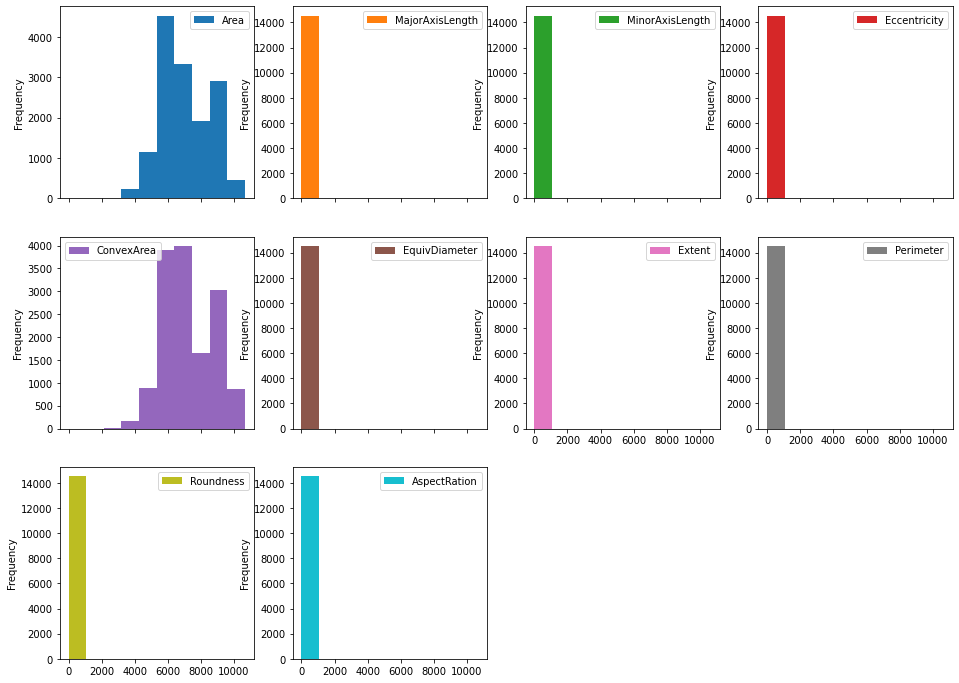

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

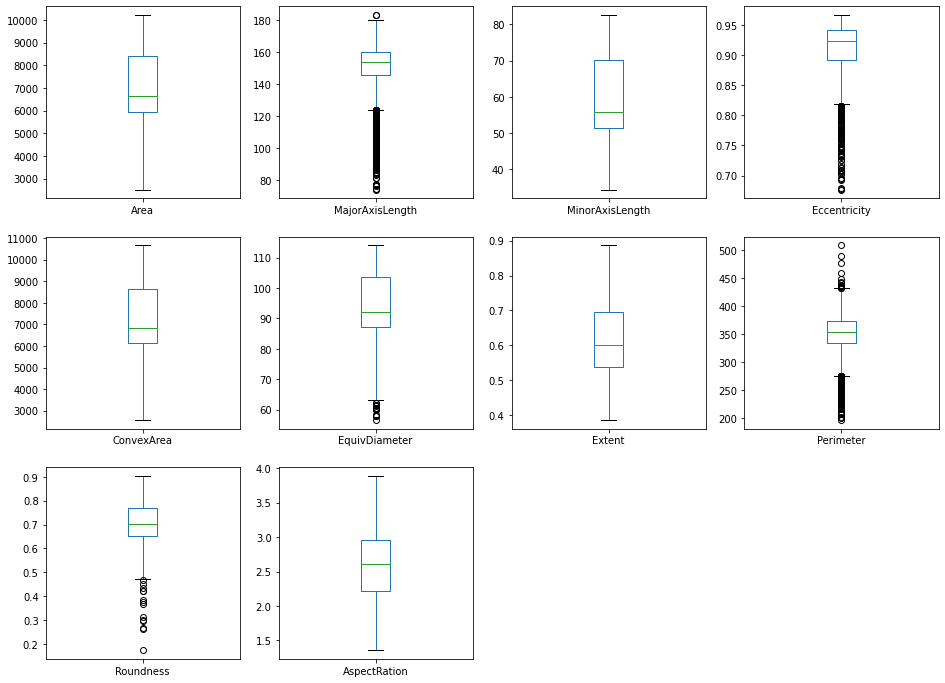

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

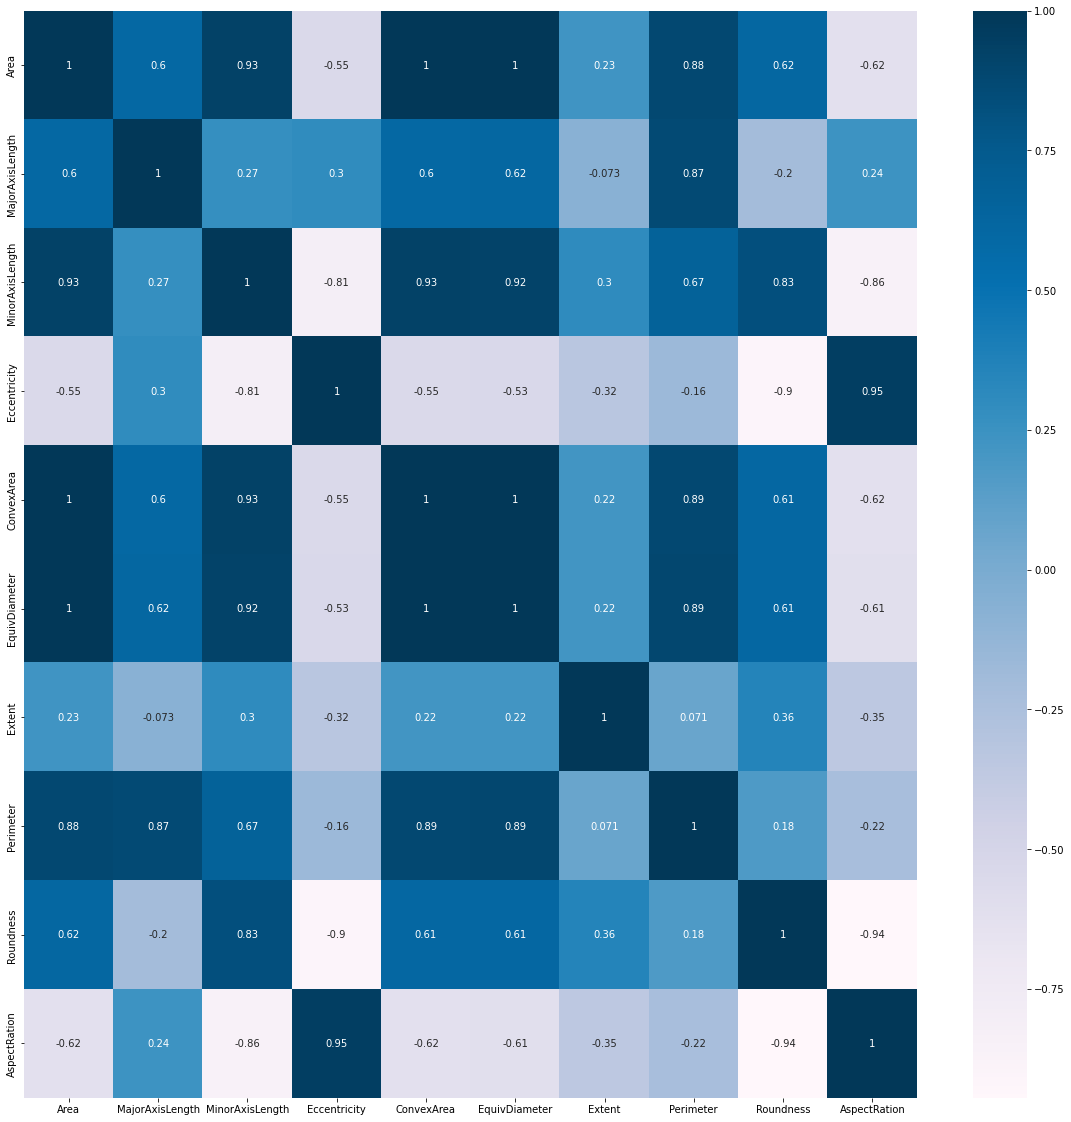

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [28]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    # ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    # ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 10
Number of categorical columns: 0
Total number of columns in the feature dataframe: 10


In [29]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (14548, 10) to array_features_train.shape: (14548, 10)


### 3.b) Training Data Balancing

In [30]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [31]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [32]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
# array_target_train = df_target_train.ravel()
class_encoder = preprocessing.LabelEncoder()
array_target_train = class_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (14548, 10) array_target_train.shape: (14548,)


In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [34]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [35]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist'))]

In [36]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.990377 (0.000376)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
Model training time: 0:00:01.050172 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


### 4.b) Algorithm Tuning

In [37]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [38]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 1001, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best: 0.990377 using {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.990377 (0.000376) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.989689 (0.001087) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.989483 (0.000708) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.989208 (0.001033) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.988933 (0.001381) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.988864 (0.001315) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
0.989002 (0.001457) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700}
0.988590 (0.001527) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800}
0.988452 (0.001649) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 900}
0.988383 (0.001398) with: {'max_depth': 3, 'min_child_weight': 1, 'n_esti

[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  5.6min finished


In [39]:
best_value_list = list(grid_result1.best_params_.values())
best_max_depth = best_value_list[0]
print("Captured the best parameter for max_depth:", best_max_depth)
best_min_child_weight = best_value_list[1]
print("Captured the best parameter for min_child_weight:", best_min_child_weight)
best_n_estimators = best_value_list[2]
print("Captured the best parameter for n_estimators:", best_n_estimators)

Captured the best parameter for max_depth: 3
Captured the best parameter for min_child_weight: 1
Captured the best parameter for n_estimators: 100


In [40]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_child_weight=best_min_child_weight,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]), colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.990377 using {'colsample_bytree': 1.0, 'subsample': 1.0}
0.989621 (0.001029) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.989895 (0.000886) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.989758 (0.001348) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.990033 (0.000948) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.990170 (0.000674) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.989827 (0.000771) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.989964 (0.001052) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.990170 (0.000709) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.990033 (0.001020) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.990033 (0.000948) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.990308 (0.000667) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.990170 (0.000467) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.989827 (0.001100) with: {'colsam

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    9.9s finished


In [41]:
best_value_list = list(grid_result2.best_params_.values())
best_colsample_bytree = best_value_list[0]
print("Captured the best parameter for colsample_bytree:", best_colsample_bytree)
best_subsample = best_value_list[1]
print("Captured the best parameter for subsample:", best_subsample)

Captured the best parameter for colsample_bytree: 1.0
Captured the best parameter for subsample: 1.0


In [42]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model3 = XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_child_weight=best_min_child_weight,
                            colsample_bytree=best_colsample_bytree, subsample=best_subsample,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_3')
paramGrid3 = dict(learning_rate=np.array([0.1, 0.05, 0.01, 0.005]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid3 = GridSearchCV(estimator=tune_model3, param_grid=paramGrid3, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result3 = grid3.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
tune_results.append(grid_result3.cv_results_['mean_test_score'])
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #3 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.990377 using {'learning_rate': 0.1}
0.990377 (0.000376) with: {'learning_rate': 0.1}
0.989345 (0.001376) with: {'learning_rate': 0.05}
0.989071 (0.001029) with: {'learning_rate': 0.01}
0.989002 (0.001043) with: {'learning_rate': 0.005}
Model training time: 0:00:02.522383


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.4s finished


In [43]:
best_value_list = list(grid_result3.best_params_.values())
best_learning_rate = best_value_list[0]
print("Captured the best parameter for learning_rate:", best_learning_rate)

Captured the best parameter for learning_rate: 0.1


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


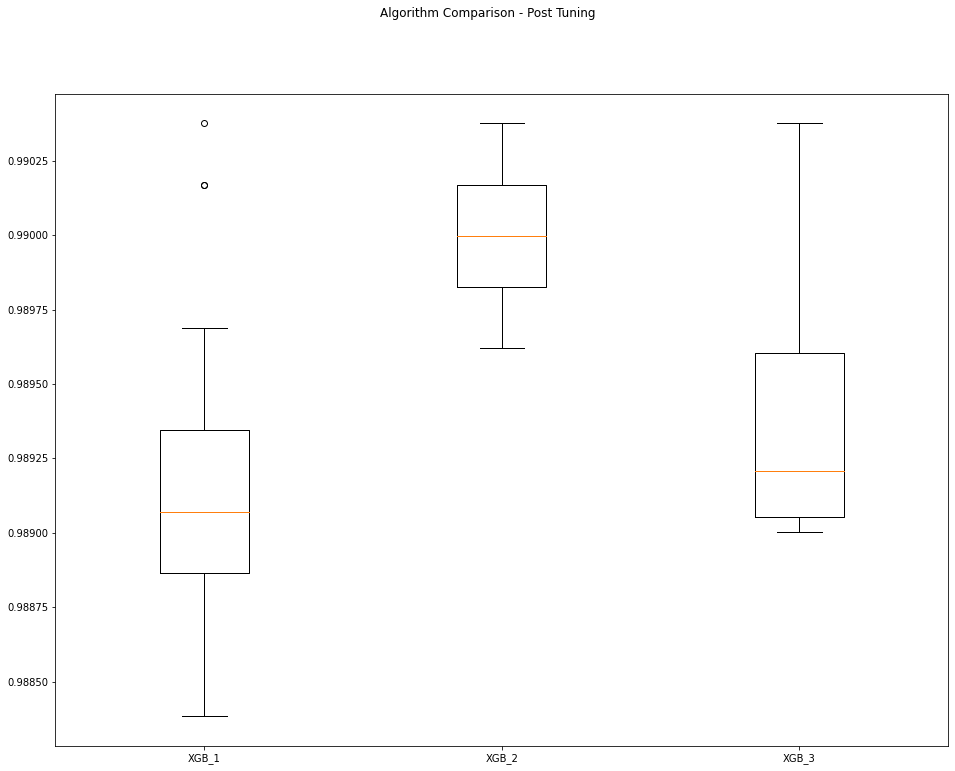

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [47]:
final_model = XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, min_child_weight=best_min_child_weight,
                            colsample_bytree=best_colsample_bytree, subsample=best_subsample, learning_rate=best_learning_rate,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, tree_method='gpu_hist', verbosity=1)


### 6.b) Load Test Dataset and Prepare the Submission File

In [48]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
array_target_test = class_encoder.transform(df_target_test)
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (3637, 10) array_target_test.shape: (3637,)


In [49]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9879021171295024
ROC/AUC Score: 0.9877844205332389
[[1618   22]
 [  22 1975]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1640
           1       0.99      0.99      0.99      1997

    accuracy                           0.99      3637
   macro avg       0.99      0.99      0.99      3637
weighted avg       0.99      0.99      0.99      3637



In [50]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:05:53.812020
